In [1]:
%matplotlib inline

In [19]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [3]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from milleniumcohort import create_config
config = create_config('../config.yml')

In [4]:
model1_path = os.path.join(config.model_path, '../mod_10st_0b_15r_720t_acceleration')
model2_path = os.path.join(config.model_path, '../mod_10st_0b_15r_720t_acceleration_anglex_angley_anglez')

In [9]:
conn1 = sqlite3.connect(os.path.join(model1_path, 'milleniumcohort.db'))
model1_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn1)
model1_times = model1_times_long.pivot('filename', 'state')

In [10]:
conn2 = sqlite3.connect(os.path.join(model2_path, 'milleniumcohort.db'))
model2_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn2)
model2_times = model2_times_long.pivot('filename', 'state')

In [11]:
cutoff_times_long = pd.read_sql('Select filename, heuristic, count(*) from data_with_states group by filename, heuristic', conn1)
cutoff_times = cutoff_times_long.pivot('filename', 'heuristic')

In [12]:
conn1.close()
conn2.close()

In [14]:
# Are the filenames the same?
np.all(model1_times.index == model2_times.index)

True

In [15]:
def table_to_X(times, min_hours = 20):
    total_5sec = times.sum(axis=1)
    times_norm = times.divide(total_5sec, axis='index')
    times_norm = times_norm[total_5sec>min_hours*60*12]
    times_norm = times_norm.fillna(0)
    X = times_norm.as_matrix()
    return X

In [16]:
X_cutoff = table_to_X(cutoff_times)
X_model1 = table_to_X(model1_times)
X_model2 = table_to_X(model2_times)

## PCA

In [20]:
pca_cutoff = PCA(n_components=X_cutoff.shape[1])
pca_cutoff.fit(X_cutoff)

pca_model1 = PCA(n_components=X_model1.shape[1])
pca_model1.fit(X_model1)

pca_model2 = PCA(n_components=X_model2.shape[1])
pca_model2.fit(X_model2)

PCA(copy=True, n_components=10, whiten=False)

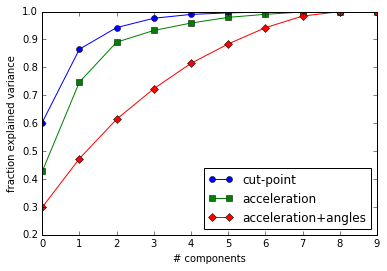

In [46]:
plt.plot(np.cumsum(pca_cutoff.explained_variance_ratio_), label='cut-point', marker='o')
plt.plot(np.cumsum(pca_model1.explained_variance_ratio_), label='acceleration', marker='s')
plt.plot(np.cumsum(pca_model2.explained_variance_ratio_), label='acceleration+angles', marker='D')
plt.xlabel('# components')
plt.ylabel('fraction explained variance')
plt.legend(loc=4)
plt.show()

In [47]:
cumvars = pd.DataFrame({'acceleration': np.cumsum(pca_model1.explained_variance_ratio_),
                        'acceleration+angles': np.cumsum(pca_model2.explained_variance_ratio_),
              'cut-point': np.cumsum(pca_cutoff.explained_variance_ratio_)})
cumvars.index = np.arange(1, 11)
cumvars

,acceleration,acceleration+angles,cut-point
1,0.427021,0.298421,0.602489
2,0.747319,0.472888,0.865201
3,0.890441,0.614171,0.942725
4,0.932423,0.723598,0.976155
5,0.958923,0.814668,0.989934
6,0.979353,0.883950,0.995426
7,0.990285,0.942428,0.998366
8,0.998683,0.983887,0.999913
9,1.000000,1.000000,1.000000
10,1.000000,1.000000,1.000000


## Correlation

In [30]:
def get_pcolorplot(correlations, ax, cmap='coolwarm', vmin=-1, vmax=1, xlabels=None, ylabels=None):
    ax.pcolor(correlations, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_yticks(np.arange(correlations.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(correlations.shape[1]) + 0.5, minor=False)
    if xlabels is None:
        xlabels = range(correlations.shape[0])
    if ylabels is None:
        ylabels2 = range(correlations.shape[1])
    else:
        ylabels2 = ylabels
    ax.invert_yaxis()
    ax.set_xticklabels(xlabels, minor=False)
    ax.set_yticklabels(ylabels2, minor=False)

In [31]:
cor_model1 = np.corrcoef(X_model1.transpose())
cor_model2 = np.corrcoef(X_model2.transpose())
cor_cutoff = np.corrcoef(X_cutoff.transpose())

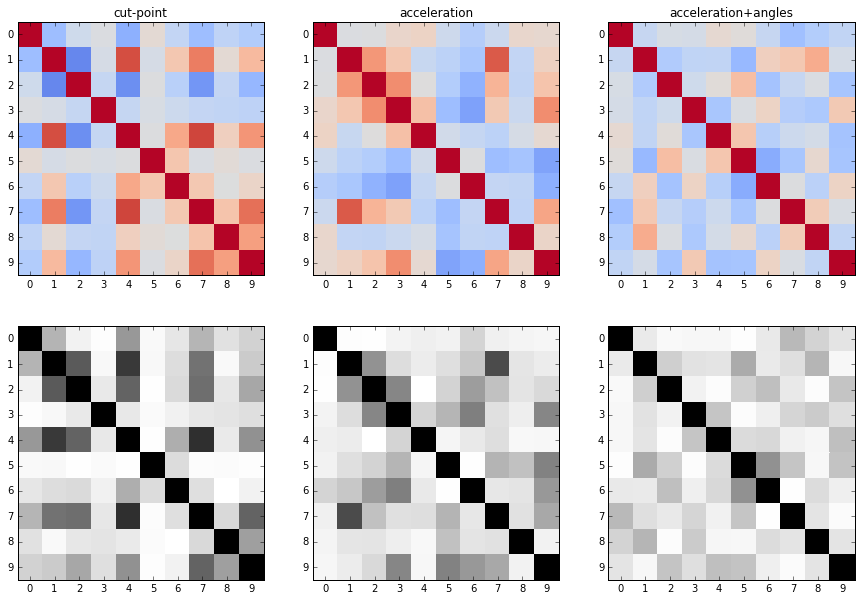

In [48]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
get_pcolorplot(cor_cutoff, axes[0,0])
get_pcolorplot(cor_model1, axes[0,1])
get_pcolorplot(cor_model2, axes[0,2])
get_pcolorplot(np.abs(cor_cutoff), axes[1,0], plt.cm.Greys, 0, 1)
get_pcolorplot(np.abs(cor_model1), axes[1,1], plt.cm.Greys, 0, 1)
get_pcolorplot(np.abs(cor_model2), axes[1,2], plt.cm.Greys, 0, 1)

axes[0,0].set_title('cut-point')
axes[0,1].set_title('acceleration')
axes[0,2].set_title('acceleration+angles')

In [35]:
cor_cutoff_values = cor_cutoff[~np.eye(cor_cutoff.shape[0], dtype=bool)]
cor_model1_values = cor_model1[~np.eye(cor_model1.shape[0], dtype=bool)]
cor_model2_values = cor_model2[~np.eye(cor_model1.shape[0], dtype=bool)]

print('cutoff: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_cutoff_values)), np.std(np.abs(cor_cutoff_values))))
print('acceleration: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_model1_values)), np.std(np.abs(cor_model1_values))))
print('acceleration+angles: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_model2_values)), np.std(np.abs(cor_model2_values))))

cutoff: 0.27±0.24
acceleration: 0.25±0.18
acceleration+angles: 0.20±0.13


In [36]:
print('cutoff: {}'.format(sum(np.abs(cor_cutoff_values)>.5)))
print('acceleration: {}'.format(sum(np.abs(cor_model1_values)>.5)))
print('acceleration+angles: {}'.format(sum(np.abs(cor_model2_values)>.5)))

cutoff: 16
acceleration: 12
acceleration+angles: 2
